This notebook contains experiments described in the following workshop paper, revealing major data leakage in most of the recent data splits of PPI complexes:
```
@inproceedings{
bushuiev2024revealing,
title={Revealing data leakage in protein interaction benchmarks},
author={Anton Bushuiev and Roman Bushuiev and Jiri Sedlar and Tomas Pluskal and Jiri Damborsky and Stanislav Mazurenko and Josef Sivic},
booktitle={ICLR 2024 Workshop on Generative and Experimental Perspectives for Biomolecular Design},
year={2024},
url={https://openreview.net/forum?id=ORMXYUK5IY}
}
```

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import random
import pickle
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
import graphein
from pandarallel import pandarallel
from tqdm import tqdm
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from loguru import logger as log

from mutils.pdb import pdb2fasta
from mutils.proteins import parse_fasta
from ppiref.split import read_fold, write_split
from ppiref.utils.ppipath import *
from ppiref.utils.ppi import PPI
from ppiref.comparison import IDist, IAlign
from ppiref.definitions import PPIREF_DATA_DIR, PPIREF_SPLITS_DIR, PPIREF_ROOT_DIR
from mutils.io import init_plotting

tqdm.pandas()

log.disable('graphein')

[04/02/24 20:42:34] WARNING  To use the Graphein submodule                                         ]8;id=209715;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=753565;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py#34\34]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             torch                                                                                 
                             To do so, use the following command: conda install -c pytorch torch                   

                    WARNING  To use the Graphein submodule                                         ]8;id=754388;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=403010;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/features/sequence/embeddings.py#45\45]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

                    WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=23104;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=2246;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/visualisation.py#36\36]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=594235;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=100680;file:///home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/graphein/protein/meshes.py#30\30]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

In [6]:
# In this notebook, we use 5 random seeds (0, 1, 2, 3, 4) to generate 5 different splits for each split type.
seed = 0

def set_seed(s):
    random.seed(s)
    np.random.seed(s)

set_seed(seed)

In [7]:
dir_ppi = Path(PPIREF_DATA_DIR / 'ppiref/ppi_6A')
dir_pdb = Path(PPIREF_ROOT_DIR / 'data/pdb')

In [8]:
tmp_dir = PPIREF_DATA_DIR / 'splits_tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

dir_splits = PPIREF_SPLITS_DIR / 'synthetic'
dir_splits.mkdir(parents=True, exist_ok=True)

# Sample PPIs from PPIRef

In [6]:
ppi_paths = read_fold('ppiref_6A_filtered', 'whole')
pdb_ids = set([path_to_pdb_id(p) for p in ppi_paths])
len(ppi_paths), len(pdb_ids)

(349685, 99401)

In [7]:
pdb_ids_sample = set(random.sample(list(pdb_ids), 15_000))
ppi_paths_sample = [p for p in ppi_paths if path_to_pdb_id(p) in pdb_ids_sample]
ppi_ids_sample = [path_to_ppi_id(p) for p in ppi_paths_sample]
len(ppi_paths_sample), len(pdb_ids_sample)

(52804, 15000)

# Sequence similarity

### Extract all protein sequences into .fasta from .pdb files for PPIs

In [8]:
import multiprocessing
from tqdm import tqdm
from pathlib import Path

def process_pdb(pdb):
    try:
        return pdb2fasta(dir_pdb / pdb_id_to_nested_suffix(pdb), verbose=False)
    except Exception as e:
        print(f'Error processing {pdb}: {e}')
        return ''

def parallel_pdb_to_fasta(pdb_ids):
    with multiprocessing.Pool(processes=16) as pool:
        fasta_parts = list(tqdm(pool.imap(process_pdb, pdb_ids), total=len(pdb_ids)))
    return ''.join(fasta_parts)

fasta = parallel_pdb_to_fasta(pdb_ids_sample)

100%|██████████| 15000/15000 [02:49<00:00, 88.69it/s] 


In [10]:
with open(tmp_dir / f'seqs_{seed}.fasta', 'w') as handle:
    handle.write(fasta)

with open(tmp_dir / f'ppis_{seed}.pkl', 'wb') as handle:
    pickle.dump(ppi_ids_sample, handle)

### Run MMseqs2

```
mmseqs easy-cluster ../PPIRef/ppiref/data/splits_tmp/seqs_0.fasta ppiref_synthetic_splits/clusterRes_0 tmp --min-seq-id 0.3
```

In [17]:
# Run 5 times for all seeds 0-4 to create 5 splits
seed = 0

In [18]:
path_mmseqs2_clusters = f'/scratch/project/open-26-23/antonb/MMseqs2/ppiref_synthetic_splits/clusterRes_{seed}_cluster.tsv'
df_mmseqs2 = pd.read_csv(path_mmseqs2_clusters, sep='\t', header=None)
df_mmseqs2 = df_mmseqs2.to_numpy()
with open(tmp_dir / f'ppis_{seed}.pkl', 'rb') as handle:
    ppi_ids_sample = pickle.load(handle)
pdb_ids_sample = [x.split('_')[0].upper() for x in ppi_ids_sample]

In [19]:
# Map clusters to nodes
mapping = defaultdict(list)
for c, n in df_mmseqs2:
    mapping[c].append(n)

# Create graph
g = ig.Graph()

# Add nodes
for c, n in df_mmseqs2:
    g.add_vertex(n)

# Add PPI edges
edges = []
for ppi in ppi_ids_sample:
    pdb, partners = ppi.split('_')[0], ppi.split('_')[1:]
    n0, n1 = pdb.upper() + ':' + partners[0], pdb.upper() + ':' + partners[1]
    edges.append((n0, n1))

# Add MMseqs2 edges
for c, ns in tqdm(mapping.items()):
    for n0 in ns:
        for n1 in ns:
            edges.append((n0, n1))
g.add_edges(edges)

# Get connect components
components = g.connected_components().subgraphs()
len(components)

100%|██████████| 9676/9676 [00:00<00:00, 14104.14it/s]


5602

In [30]:
components_train, components_test = train_test_split(components, test_size=0.1, random_state=42)
nodes_train = sum([g.vs()['name'] for g in components_train], start=[])
nodes_test = sum([g.vs()['name'] for g in components_test], start=[])

folds = defaultdict(list)
for ppi in tqdm(ppi_ids_sample):
    pdb, partners = ppi.split('_')[0], ppi.split('_')[1:]
    n0, n1 = pdb.upper() + ':' + partners[0], pdb.upper() + ':' + partners[1]
    if n0 in nodes_train:
        assert n1 in nodes_train
        folds['train'].append(ppi)
    elif n1 in nodes_test:
        assert n1 in nodes_test
        folds['test'].append(ppi)
    else:
        raise RuntimeError(f'{n0} is not in folds.')

len(folds['train']), len(folds['test'])

100%|██████████| 53344/53344 [00:42<00:00, 1244.07it/s]


(49757, 3587)

In [31]:
write_split(dir_splits / f'seq_{seed}.json', dir_ppi, folds)

/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53344 of 765139 PPIs contained.
  warnings.warn(


# Random split (PDB + partners codes)

In [125]:
for seed in range(5):
    set_seed(seed)

    with open(tmp_dir / f'ppis_{seed}.pkl', 'rb') as handle:
        ppi_ids_sample = pickle.load(handle)
    
    ppi_ids_sample_train, ppi_ids_sample_test = train_test_split(ppi_ids_sample, test_size=0.1, random_state=42)
    folds = {'train': ppi_ids_sample_train, 'test': ppi_ids_sample_test}
    write_split(dir_splits / f'random_{seed}.json', dir_ppi, folds)

/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 52804 of 765139 PPIs contained.
  warnings.warn(
/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53341 of 765139 PPIs contained.
  warnings.warn(
/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 54224 of 765139 PPIs contained.
  warnings.warn(
/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 54349 of 765139 PPIs contained.
  warnings.warn(
/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53344 of 765139 PPIs contained.
  warnings.warn(


# PDB code split


In [130]:
for seed in tqdm(range(5)):
    set_seed(seed)

    with open(tmp_dir / f'ppis_{seed}.pkl', 'rb') as handle:
        ppi_ids_sample = pickle.load(handle)
    
    pdb_ids_sample = list(set([x.split('_')[0] for x in ppi_ids_sample]))
    pdb_ids_sample_train, pdb_ids_sample_test = train_test_split(pdb_ids_sample, test_size=0.1, random_state=42)
    pdb_ids_sample_train, pdb_ids_sample_test = set(pdb_ids_sample_train), set(pdb_ids_sample_test)

    ppi_ids_sample_train = [x for x in ppi_ids_sample if x.split('_')[0] in pdb_ids_sample_train]
    ppi_ids_sample_test = [x for x in ppi_ids_sample if x.split('_')[0] in pdb_ids_sample_test]
    
    folds = {'train': ppi_ids_sample_train, 'test': ppi_ids_sample_test}
    write_split(dir_splits / f'pdb_{seed}.json', dir_ppi, folds)

  0%|          | 0/5 [00:00<?, ?it/s]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 52804 of 765139 PPIs contained.
  warnings.warn(
 20%|██        | 1/5 [00:07<00:28,  7.13s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53341 of 765139 PPIs contained.
  warnings.warn(
 40%|████      | 2/5 [00:14<00:22,  7.55s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 54224 of 765139 PPIs contained.
  warnings.warn(
 60%|██████    | 3/5 [00:22<00:15,  7.73s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 54349 of 765139 PPIs contained.
  warnings.warn(
 80%|████████  | 4/5 [00:30<00:07,  7.51s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53344 of 765139 PPIs contained.
  warnings.warn(
100%|██████████| 5/5 [00:38<00:00,  7.62s/it]


# Time split

In [150]:
def ppi_file_to_df_row(path):
    ppi = PPI(path)
    if path.suffix == '.noppi':
        return {}
    return {'PATH': path, **ppi.stats}

df_path = PPIREF_DATA_DIR / 'ppiref/ppi_6A_stats/raw_stats.csv'

df = pd.read_csv(df_path, dtype={'PATH': str, 'KIND': str, 'STRUCTURE METHOD': str})
pd.to_datetime(df['DEPOSITION DATE'], format='%Y-%m-%d')
pd.to_datetime(df['RELEASE DATE'], format='%Y-%m-%d')

df = df.dropna(how='all')

df['PPI'] = df['PATH'].apply(lambda x: path_to_ppi_id(x))
df = df.set_index('PPI')

df

,PATH,KIND,EXTRACTION RADIUS,EXPANSION RADIUS,RESOLUTION,STRUCTURE METHOD,DEPOSITION DATE,RELEASE DATE,BSA
PPI,,,,,,,,,
6q2a_F_O,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,2.60,x-ray diffraction,2019-08-07,2020-06-17,659.734682
3q2k_I_P,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,2.13,x-ray diffraction,2010-12-20,2011-01-19,50.450693
8q2k_A_C,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,2.88,electron microscopy,2023-08-02,2023-08-30,3079.544686
4q2k_A_D,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,2.20,x-ray diffraction,2014-04-09,2014-07-23,462.436532
6q27_B_D,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,2.20,x-ray diffraction,2019-08-07,2020-01-22,689.826471
...,...,...,...,...,...,...,...,...,...
4s20_C_I,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,4.70,x-ray diffraction,2015-01-16,2015-02-04,281.223175
1s2g_A_B,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,2.10,x-ray diffraction,2004-01-08,2004-03-30,887.002861
3s2d_A_F,/scratch/project/open-26-23/antonb/PPIRef/ppir...,heavy,6.0,0.0,3.20,x-ray diffraction,2011-05-16,2011-08-10,1807.687696


In [156]:
for seed in tqdm(range(5)):
    set_seed(seed)

    with open(tmp_dir / f'ppis_{seed}.pkl', 'rb') as handle:
        ppi_ids_sample = pickle.load(handle)
    
    df_sample = df.loc[ppi_ids_sample]
    df_sample = df_sample.sort_values('DEPOSITION DATE')
    cutoff = int(len(df_sample) * 0.9)
    df_sample_train = df_sample.iloc[:cutoff]
    df_sample_test = df_sample.iloc[cutoff:]

    ppi_ids_sample_train = set(df_sample_train.index)
    ppi_ids_sample_test = set(df_sample_test.index)

    folds = {'train': ppi_ids_sample_train, 'test': ppi_ids_sample_test}
    write_split(dir_splits / f'time_{seed}.json', dir_ppi, folds)

  0%|          | 0/5 [00:00<?, ?it/s]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 52804 of 765139 PPIs contained.
  warnings.warn(
 20%|██        | 1/5 [00:06<00:27,  6.98s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53341 of 765139 PPIs contained.
  warnings.warn(
 40%|████      | 2/5 [00:15<00:24,  8.14s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 54224 of 765139 PPIs contained.
  warnings.warn(
 60%|██████    | 3/5 [00:22<00:15,  7.65s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 54349 of 765139 PPIs contained.
  warnings.warn(
 80%|████████  | 4/5 [00:30<00:07,  7.74s/it]/scratch/project/open-26-23/antonb/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 53344 of 765139 PPIs contained.
  warnings.warn(
100%|██████████| 5/5 [00:38<00:00,  7.75s/it]


# Estimate leakage

In [8]:
df_leaks = []

path_emb = Path(PPIREF_DATA_DIR / 'ppiref/clustering/idist_emb_ppiref_6A_filtered,whole.csv')
path_emb = Path(path_emb)
df_emb = pd.read_csv(path_emb, index_col=0)

for path in tqdm(list(dir_splits.glob('*.json'))):

    ppi_ids_train = read_fold(path, 'train', full_paths=False)
    ppi_ids_test = read_fold(path, 'test', full_paths=False)

    print(len(ppi_ids_train) + len(ppi_ids_test))

    df_emb_train = df_emb.loc[ppi_ids_train]
    df_emb_test = df_emb.loc[ppi_ids_test]

    idist = IDist()
    idist.read_embeddings(df_emb_train, dropna=True)

    df_emb_test = df_emb_test.replace(np.nan, 0.0)
    idist_hits = idist.query(df_emb_test.to_numpy())
    df_emb_test['idist_hits'] = [len(row_hits) for row_hits in idist_hits[0]]

    n_leaks = df_emb_test['idist_hits'].astype(bool).mean()
    df_leaks.append({'Split': path.stem, 'Leakage': n_leaks})

  0%|          | 0/20 [00:00<?, ?it/s]

54349


  5%|▌         | 1/20 [00:02<00:56,  2.98s/it]

53341


 10%|█         | 2/20 [00:05<00:53,  2.98s/it]

53341


 15%|█▌        | 3/20 [00:08<00:49,  2.90s/it]

54224


 20%|██        | 4/20 [00:11<00:46,  2.92s/it]

54224


 25%|██▌       | 5/20 [00:14<00:44,  2.96s/it]

53344


 30%|███       | 6/20 [00:17<00:41,  2.96s/it]

52804


 35%|███▌      | 7/20 [00:20<00:38,  2.97s/it]

53344


 40%|████      | 8/20 [00:23<00:35,  2.99s/it]

53344


 45%|████▌     | 9/20 [00:26<00:32,  2.99s/it]

53344


 50%|█████     | 10/20 [00:29<00:29,  3.00s/it]

53341


 55%|█████▌    | 11/20 [00:32<00:26,  2.97s/it]

52804


 60%|██████    | 12/20 [00:35<00:23,  2.94s/it]

54349


 65%|██████▌   | 13/20 [00:38<00:20,  2.95s/it]

52804


 70%|███████   | 14/20 [00:41<00:17,  2.92s/it]

53341


 75%|███████▌  | 15/20 [00:44<00:14,  2.85s/it]

54349


 80%|████████  | 16/20 [00:46<00:11,  2.84s/it]

54224


 85%|████████▌ | 17/20 [00:49<00:08,  2.83s/it]

54224


 90%|█████████ | 18/20 [00:52<00:05,  2.85s/it]

52804


 95%|█████████▌| 19/20 [00:55<00:02,  2.89s/it]

54349


100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


In [9]:
df_leaks.append({'Split': 'interface', 'Leakage': 0})

In [10]:
df_leaks = pd.DataFrame(df_leaks)
df_leaks['Split kind'] = df_leaks['Split'].apply(lambda x: x.split('_')[0])
df_leaks = df_leaks.sort_values('Leakage', ascending=False)
df_leaks

,Split,Leakage,Split kind
12,random_3,0.866605,random
4,random_2,0.865019,random
1,random_1,0.863543,random
11,random_0,0.857035,random
9,random_4,0.853983,random
17,pdb_2,0.697821,pdb
13,pdb_0,0.650706,pdb
8,time_4,0.650047,time
10,pdb_1,0.634474,pdb
14,time_1,0.630178,time


## Plot

In [10]:
init_plotting()

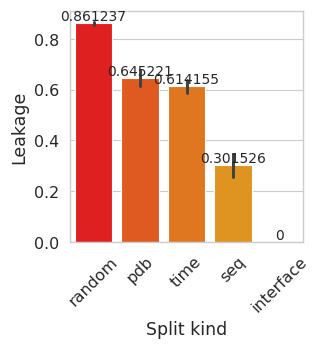

In [11]:
plt.figure(figsize=(3, 3))
palette = list(reversed(['#ffc100',
'#ff9a00',
'#ff7400',
'#ff4d00',
'#ff0000']))
ax = sns.barplot(data=df_leaks, x='Split kind', y='Leakage', errorbar=('sd'), palette=sns.color_palette(palette, 4))
ax.bar_label(ax.containers[0], fontsize=10)
# plt.xticks([])
# plt.yticks([])
# plt.xlabel('')
# plt.ylabel('')
plt.xticks(rotation=45)
# plt.yrange = (0, 1)
plt.show()

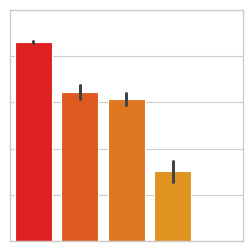

In [12]:
plt.figure(figsize=(3, 3))
# palette = ['#F50662', '#7AFFAE', '#51FFFF', '#FF9E51']  # '#005CFF', 
ax = sns.barplot(data=df_leaks, x='Split kind', y='Leakage', errorbar=('sd'), palette=sns.color_palette(palette, 4))
# ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim([0, 1])
# plt.xticks(rotation=45)
# plt.yrange = (0, 1)
# plt.yticks = [0, 0.2, 0.4, 0.6, 0.8, 1]
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# ax.get_yaxis().set_xticks([])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.xticks = []
plt.yticks = []
plt.xlabel('')
plt.ylabel('')
plt.savefig('leakage.svg', bbox_inches='tight')
plt.show()

# Real datasets

### SKEMPI v2.0

In [54]:
# path = 'dips_equidock_ppiref_source'
# path_emb = Path(PPIREF_DATA_DIR / 'ppiref/clustering/idist_emb_dips_equidock_ppiref_source,whole.csv')

path = 'skempi2_cleaned_rde_net'
path_emb = Path(PPIREF_DATA_DIR / 'skempi2/clustering/idist_emb_skempi2_cleaned_rde_net,whole.csv')

path_emb = Path(path_emb)
df_emb = pd.read_csv(path_emb, index_col=0)

ppi_ids_train = read_fold(path, '1+0', full_paths=False)
# ppi_ids_train = [x.split('_')[0].lower() + '_' + x.split('_', 1)[1] for x in ppi_ids_train]
ppi_ids_test = read_fold(path, '2', full_paths=False)
# ppi_ids_test = [x.split('_')[0].lower() + '_' + x.split('_', 1)[1] for x in ppi_ids_test]

print('Embeddings:', len(df_emb))
df_emb = df_emb.reindex(ppi_ids_train + ppi_ids_test)
print('Embeddings from folds:', len(df_emb.dropna()))

df_emb_train = df_emb.loc[ppi_ids_train]
df_emb_test = df_emb.loc[ppi_ids_test]

idist = IDist(near_duplicate_threshold=0.03)
idist.read_embeddings(df_emb_train, dropna=True)

df_emb_test = df_emb_test.replace(np.nan, 0.0)
idist_hits = idist.query(df_emb_test.to_numpy())
df_emb_test['idist_hits'] = [len(row_hits) for row_hits in idist_hits[0]]

n_leaks = df_emb_test['idist_hits'].astype(bool).mean()
n_leaks
# df_leaks.append({'Split': path.stem, 'Leakage': n_leaks})

Embeddings: 343
Embeddings from folds: 343


0.5663716814159292

In [56]:
(57 + 57 + 54) / 3

56.0

### BM5

In [9]:
# Use all extracted interfaces from DB5.5, the source of BM5 structures
ppi_dir_db5 = PPIREF_DATA_DIR / 'db5/ppi_6A'
ppi_paths_db5 = list(ppi_dir_db5.rglob('*.pdb'))
len(ppi_paths_db5)

499

In [10]:
# Compare pairwise with iDist
idist = IDist()
df_idist = idist.compare_all_against_all(ppi_paths_db5, ppi_paths_db5)
df_idist

Embedding PPIs (62 processes):  10%|▉         | 48/499 [00:00<00:04, 93.42it/s]/home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)
/home/antonb/miniconda3/envs/ppiref/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis

,PPI0,PPI1,L2,L1,Cosine Similarity
0,1ay7_A_B,1ay7_A_B,0.000000,0.000000,1.000000
1,1ay7_A_B,2ayo_A_B,0.084698,0.313266,0.798831
2,1ay7_A_B,3szk_D_E,0.092129,0.352079,0.774488
3,1ay7_A_B,3szk_D_F,0.092937,0.323894,0.775323
4,1ay7_A_B,3h11_A_B,0.069896,0.247428,0.858052
...,...,...,...,...,...
248996,4gam_F_G,2gaf_A_D,0.064190,0.191299,0.868917
248997,4gam_F_G,4gam_B_D,0.163681,0.511616,0.708764
248998,4gam_F_G,4gam_D_F,0.100634,0.380326,0.785397
248999,4gam_F_G,4gam_F_H,0.064153,0.199476,0.877176


In [31]:
# Read BM5 split from the DeepRank-GNN paper
split_bm5 = {
    # Github: https://github.com/DeepRank/Deeprank-GNN/blob/master/paper_pretrained_models/scoring_of_docking_models/BM5_CAPRI_datasets_details_csv/BM5_eval_pdb_list.csv
    'fold1': ['2NZ8', '1US7', '1NW9', '2CFH', '2O8V', '1HE1', '2OT3', '2FJU', '1GRN', '2I9B', '1ZM4', '1Z0K', '1JK9', '1ZLI', '2A5T', '3DAW', '1ZHH', '1HE8', '1MQ8', '2A9K', '2AJF', '2J7P', '1JIW', '1XD3', '2A1A'],
    'fold2': ['1R8S', '1FC2', '2VDB', '3H2V', '1FFW', '4CPA', '1R0R', '4FZA', '1LFD', '2J0T', '3FN1', '2GTP', '2HQS', '3S9D', '2UUY', '1ACB', '2PCC', '2HRK', '4H03', '1D6R', '2C0L', '1KXP', '1AVX', '1GCQ', '2BTF'],
    'fold3': ['1RKE', '1EAW', '1YVB', '2AYO', '2B42', '1BUH', '1S1Q', '1OC0', '1WQ1', '1H9D', '1UDI', '2ABZ', '1BKD', '1I2M', '3CPH', '1JTG', '1Y64', '2O3B', 'BAAD', '1PVH', '1R6Q', '7CEI', '1CLV', '1F34', '2H7V'],
    'fold4': ['BOYV', '3SGQ', '1KXQ', '2G77', '2OOB', '2SIC', '1J2J', '3F1P', '1PXV', '2GAF', '1SYX', '4M76', '1GXD', '1B6C', '3VLB', '1GHQ', '1DFJ', '3BIW', '1KAC', '3PC8', '1ATN', '1FLE', '1T6B', '1TMQ', '1M10'],
    'fold5': ['1FQJ', '2IDO', '1EFN', '2OUL', '1FQ1', '1SBB', '1MAH', '2X9A', '1QA9', '1ZHI', '1AY7', '1E96', '1GPW', '3D5S', '1KTZ', '1JTD', '3AAD', '3A4S', '1E6E', '3BX7', '1EWY', '1Z5Y', '1GL1', '4IZ7', '2I25'],
    'fold6': ['1JIW', '4M76', '3S9D', '1KXQ', '2UUY', '1QA9', '1LFD', '2B42', '2PCC', '1KAC', '1XD3', '1E6E', '1R8S', '1HE8', '3BIW', '1GHQ', '1Y64', '1CLV', '1I2M', '1AY7', '1M10', '3BX7', '1GXD', 'BAAD', '2NZ8'],
    'fold7': ['1Z5Y', '3H2V', '4IZ7', '2A9K', '1MQ8', '1B6C', '1DFJ', '3A4S', '1SBB', '2C0L', '1ZHH', '3VLB', '1SYX', '2J7P', '1GRN', '1US7', '2G77', '2A1A', '1R0R', '1PXV', '2OUL', '1ACB', '1EWY', '3F1P', '2A5T'],
    'fold8': ['1OC0', '2ABZ', '1HE1', '1KTZ', '3PC8', '4FZA', '3SGQ', '1YVB', '1Z0K', '2AYO', '2HQS', '4H03', '1JTG', '1GCQ', '2HRK', '1RKE', '1FC2', '1UDI', '2IDO', '1ZM4', '1BUH', '1H9D', '1FQJ', '1NW9', '1MAH'],
    'fold9': ['2O8V', '1FLE', '4CPA', '2GAF', '2I9B', '1ZHI', '3DAW', '1ATN', '1T6B', '1EFN', '2AJF', '2X9A', '2H7V', '2BTF', '2I25', '1E96', '2HLE', '1GPW', '1F34', '7CEI', '3FN1', '1GLA', 'BOYV', '1JK9', '1FFW'],
    'fold10': ['1AVX', '1WQ1', '1ZLI', '2OOB', '1PVH', '1EAW', '2VDB', '2J0T', '1FQ1', '1R6Q', '3CPH', '2CFH', '1BKD', '1J2J', '2O3B', '1TMQ', '3D5S', '1S1Q', '1D6R', '1GL1', '2OT3', '1KXP', '2GTP', '2SIC', '3AAD'],
}

In [33]:
# Create subset of DB5.5 comparisons relevant for the BM5 split
def f(row):
    # Return True if the PPIs are in different folds of DeepRank-GNN split of BM5
    pdb0, pdb1 = row['PPI0'].split('_', 1)[0].upper(), row['PPI1'].split('_', 1)[0].upper()

    if pdb0 == pdb1:
        return False

    fold0, fold1 = None, None
    for fold, pdbs in split_bm5.items():
        if pdb0 in pdbs:
            fold0 = fold
        if pdb1 in pdbs:
            fold1 = fold

    if fold0 is None or fold1 is None:
        return False
    
    return fold0 != fold1

df_idist_bm5 = df_idist[df_idist.apply(f, axis=1)]
# df_idist_bm5.sort_values('L2')
df_hits = df_idist_bm5[df_idist_bm5['L2'] < 0.04]
display(df_hits)
print(set(df_hits['PPI0'].tolist() + df_hits['PPI1'].tolist()))

,PPI0,PPI1,L2,L1,Cosine Similarity
149626,2nz8_A_B,1bkd_R_S,0.038227,0.119715,0.954367
212374,1bkd_R_S,2nz8_A_B,0.038227,0.119715,0.954367


{'2nz8_A_B', '1bkd_R_S'}
